In [1]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import optuna
from itertools import combinations
import shutup

shutup.please()

In [2]:
data = pd.read_csv('Dataset.csv', dtype={'feature1': np.int8, 'feature2': np.int8, 'feature3': np.int8, 'index_return': str})
data['index_return'] = data['index_return'].str.rstrip('%').astype('float') / 100.0
data['index_return'] = data['index_return'].shift(-1)  # 很重要，当天预测的是第二天的收益率
data

,day,feature1,feature2,feature3,index_return
0,1,9,59,72,0.0010
1,2,5,17,64,0.0002
2,3,20,38,69,-0.0029
3,4,14,15,66,-0.0115
4,5,14,18,61,0.0036
...,...,...,...,...,...
700,701,3,14,20,0.0092
701,702,18,21,46,-0.0010
702,703,2,2,42,-0.0049
703,704,2,5,41,0.0052


In [3]:
def reduce_mem_usage(df, verbose=0):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """

    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    if verbose:
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        print(f"Decreased by {decrease:.2f}%")

    return df

# 根据已有特征构建出新的特征

由于根据现有feature无法得知具体是什么feature，因此尽可能多地根据给到地3个feature构建新的feature，并用机器学习模型预测

In [4]:
# 先构建各个feature的和与差，积与熵
ori_features = ['feature1', 'feature2', 'feature3']
for c in combinations(ori_features, 2):
    data[f"{c[0]}_{c[1]}_sum"] = data[c[0]] + data[c[1]]  # 和
    data[f"{c[0]}_{c[1]}_difference"] = data[c[0]] - data[c[1]]  # 差
    data[f"{c[0]}_{c[1]}_product"] = data[c[0]] * data[c[1]]  # 积
    data[f"{c[0]}_{c[1]}_quotient"] = data[c[0]] / data[c[1]]  # 商
data

,day,feature1,feature2,feature3,index_return,feature1_feature2_sum,feature1_feature2_difference,feature1_feature2_product,feature1_feature2_quotient,feature1_feature3_sum,feature1_feature3_difference,feature1_feature3_product,feature1_feature3_quotient,feature2_feature3_sum,feature2_feature3_difference,feature2_feature3_product,feature2_feature3_quotient
0,1,9,59,72,0.0010,68,-50,19,0.152542,81,-63,-120,0.125000,-125,-13,-104,0.819444
1,2,5,17,64,0.0002,22,-12,85,0.294118,69,-59,64,0.078125,81,-47,64,0.265625
2,3,20,38,69,-0.0029,58,-18,-8,0.526316,89,-49,100,0.289855,107,-31,62,0.550725
3,4,14,15,66,-0.0115,29,-1,-46,0.933333,80,-52,-100,0.212121,81,-51,-34,0.227273
4,5,14,18,61,0.0036,32,-4,-4,0.777778,75,-47,86,0.229508,79,-43,74,0.295082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,701,3,14,20,0.0092,17,-11,42,0.214286,23,-17,60,0.150000,34,-6,24,0.700000
701,702,18,21,46,-0.0010,39,-3,122,0.857143,64,-28,60,0.391304,67,-25,-58,0.456522
702,703,2,2,42,-0.0049,4,0,4,1.000000,44,-40,84,0.047619,44,-40,84,0.047619
703,704,2,5,41,0.0052,7,-3,10,0.400000,43,-39,82,0.048780,46,-36,-51,0.121951


In [5]:
# 下面计算移动平均指标
feature_cols = list(data.columns)
feature_cols.remove('day')
feature_cols.remove('index_return')

periods = [5, 10, 20]  # 短线操作中常用的均线参数
for ft in feature_cols:
    for period in periods:
        data[f'{ft}_{period}_mean'] = data[ft].rolling(period).mean()  # 每个feature的移动平均
        data[f'{ft}_{period}_bias'] = data[ft] / data[f'{ft}_{period}_mean'] - 1  # 每个feature的乖离度
        try:
            data[f'{ft}_{period}_vol'] = np.sqrt(data[ft].rolling(period).var())  # 每个feature的波动率
        except TypeError:
            print(data[ft].rolling(period))
            break
    for c in combinations(periods, 2):
        data[f'{ft}_{c[0]}_{c[1]}'] = data[ft].rolling(c[0]).mean() / data[ft].rolling(c[1]).mean()  # 每个feature的移动平均之比
data

,day,feature1,feature2,feature3,index_return,feature1_feature2_sum,feature1_feature2_difference,feature1_feature2_product,feature1_feature2_quotient,feature1_feature3_sum,...,feature2_feature3_quotient_5_vol,feature2_feature3_quotient_10_mean,feature2_feature3_quotient_10_bias,feature2_feature3_quotient_10_vol,feature2_feature3_quotient_20_mean,feature2_feature3_quotient_20_bias,feature2_feature3_quotient_20_vol,feature2_feature3_quotient_5_10,feature2_feature3_quotient_5_20,feature2_feature3_quotient_10_20
0,1,9,59,72,0.0010,68,-50,19,0.152542,81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,5,17,64,0.0002,22,-12,85,0.294118,69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,20,38,69,-0.0029,58,-18,-8,0.526316,89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,14,15,66,-0.0115,29,-1,-46,0.933333,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,14,18,61,0.0036,32,-4,-4,0.777778,75,...,0.251271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,701,3,14,20,0.0092,17,-11,42,0.214286,23,...,0.144241,0.516044,0.356474,0.132196,0.525114,0.333044,0.165271,1.148872,1.129028,0.982727
701,702,18,21,46,-0.0010,39,-3,122,0.857143,64,...,0.147655,0.510716,-0.106114,0.133543,0.535120,-0.146879,0.153807,1.154709,1.102049,0.954395
702,703,2,2,42,-0.0049,4,0,4,1.000000,44,...,0.287898,0.473478,-0.899427,0.198008,0.513890,-0.907336,0.188367,1.063893,0.980229,0.921361
703,704,2,5,41,0.0052,7,-3,10,0.400000,43,...,0.333390,0.449958,-0.728972,0.225431,0.503320,-0.757707,0.204288,0.940882,0.841130,0.893980


In [6]:
data = reduce_mem_usage(data, verbose=1)
data

Memory usage of dataframe is 1.00 MB
Memory usage after optimization is: 0.51 MB
Decreased by 49.39%


,day,feature1,feature2,feature3,index_return,feature1_feature2_sum,feature1_feature2_difference,feature1_feature2_product,feature1_feature2_quotient,feature1_feature3_sum,...,feature2_feature3_quotient_5_vol,feature2_feature3_quotient_10_mean,feature2_feature3_quotient_10_bias,feature2_feature3_quotient_10_vol,feature2_feature3_quotient_20_mean,feature2_feature3_quotient_20_bias,feature2_feature3_quotient_20_vol,feature2_feature3_quotient_5_10,feature2_feature3_quotient_5_20,feature2_feature3_quotient_10_20
0,1,9,59,72,0.0010,68,-50,19,0.152542,81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,5,17,64,0.0002,22,-12,85,0.294118,69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,20,38,69,-0.0029,58,-18,-8,0.526316,89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,14,15,66,-0.0115,29,-1,-46,0.933333,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,14,18,61,0.0036,32,-4,-4,0.777778,75,...,0.251271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,701,3,14,20,0.0092,17,-11,42,0.214286,23,...,0.144241,0.516044,0.356474,0.132196,0.525114,0.333044,0.165271,1.148872,1.129027,0.982727
701,702,18,21,46,-0.0010,39,-3,122,0.857143,64,...,0.147655,0.510716,-0.106114,0.133543,0.535120,-0.146879,0.153807,1.154709,1.102049,0.954395
702,703,2,2,42,-0.0049,4,0,4,1.000000,44,...,0.287898,0.473478,-0.899427,0.198008,0.513889,-0.907336,0.188367,1.063893,0.980229,0.921361
703,704,2,5,41,0.0052,7,-3,10,0.400000,43,...,0.333390,0.449958,-0.728972,0.225431,0.503320,-0.757707,0.204288,0.940882,0.841130,0.893980


## 缩尾（4%）并标准化

In [7]:
from sklearn.preprocessing import StandardScaler

feature_cols = list(data.columns)
feature_cols.remove('day')
feature_cols.remove('index_return')

scaler = StandardScaler()
data[feature_cols + ['index_return']] = data[feature_cols + ['index_return']].clip(lower=data[feature_cols + ['index_return']].quantile(0.04), upper=data[feature_cols + ['index_return']].quantile(0.96), axis=1)
data[feature_cols + ['index_return']] = pd.DataFrame(scaler.fit_transform(data[feature_cols + ['index_return']]), columns=[feature_cols + ['index_return']])
data

,day,feature1,feature2,feature3,index_return,feature1_feature2_sum,feature1_feature2_difference,feature1_feature2_product,feature1_feature2_quotient,feature1_feature3_sum,...,feature2_feature3_quotient_5_vol,feature2_feature3_quotient_10_mean,feature2_feature3_quotient_10_bias,feature2_feature3_quotient_10_vol,feature2_feature3_quotient_20_mean,feature2_feature3_quotient_20_bias,feature2_feature3_quotient_20_vol,feature2_feature3_quotient_5_10,feature2_feature3_quotient_5_20,feature2_feature3_quotient_10_20
0,1,-0.466642,1.317203,1.357251,0.117669,0.942208,-1.920112,0.181151,-0.650135,0.527213,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,-0.615909,-0.452524,0.865544,0.038288,0.008084,-0.358175,1.200372,-0.525788,0.040429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,-0.056160,0.432339,1.172861,-0.269313,0.739137,-0.748659,-0.235803,-0.321847,0.851735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,-0.280059,-0.536797,0.988470,-1.122658,0.150233,0.357713,-0.822627,0.035639,0.486647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,-0.280059,-0.410388,0.681154,0.375657,0.211154,0.162471,-0.174032,-0.100986,0.283821,...,-0.053922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,701,-0.690542,-0.578933,-1.838845,0.931324,-0.093452,-0.293094,0.536334,-0.595905,-1.622747,...,-0.339185,-0.239254,0.494242,-0.476520,-0.237888,0.289437,-0.397931,0.432678,0.141660,-0.059595
701,702,-0.130793,-0.283979,-0.240797,-0.080783,0.353303,0.227552,1.617326,-0.031279,-0.162397,...,-0.330087,-0.245885,-0.236152,-0.473627,-0.225353,-0.264600,-0.409356,0.450037,0.097192,-0.132994
702,703,-0.727858,-1.084569,-0.486650,-0.467765,-0.357443,0.422794,-0.050490,0.094193,-0.973702,...,0.043699,-0.292229,-1.455313,-0.335132,-0.251949,-1.142495,-0.374912,0.179975,-0.103598,-0.218575
703,704,-0.727858,-0.958160,-0.548114,0.534419,-0.296522,0.227552,0.042166,-0.432791,-1.014268,...,0.164947,-0.321500,-1.219603,-0.276219,-0.265190,-0.969758,-0.359044,-0.185826,-0.332869,-0.289509


# 使用LightGBM进行表格数据预测并解释特征重要性

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = data[feature_cols]
y = data['index_return']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)

# 使用LightGBM，用optuna调参
def objective(trial):
    ...

    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        'objective': 'regression',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_pre_filter': False
    }

    gbm = lgb.train(param, train_data)
    preds = gbm.predict(X_test)
    try:
        loss = mean_squared_error(y_test, preds)
    except ValueError:
        print(y_test)
    
    return loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-12-14 20:41:37,990] A new study created in memory with name: no-name-3248e342-f401-4c2a-9157-05ef1f3c4ba6
[I 2023-12-14 20:41:38,096] Trial 0 finished with value: 0.902107184956533 and parameters: {'lambda_l1': 3.3847725629400265, 'lambda_l2': 3.580268884191221e-06, 'num_leaves': 121, 'feature_fraction': 0.7405563668038072, 'bagging_fraction': 0.6852214142685529, 'bagging_freq': 1, 'min_child_samples': 78}. Best is trial 0 with value: 0.902107184956533.
[I 2023-12-14 20:41:38,142] Trial 1 finished with value: 0.908941373372138 and parameters: {'lambda_l1': 3.124310101425691e-08, 'lambda_l2': 3.4457920921459404e-05, 'num_leaves': 28, 'feature_fraction': 0.9238810427278918, 'bagging_fraction': 0.5584518539380834, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 0 with value: 0.902107184956533.
[I 2023-12-14 20:41:38,187] Trial 2 finished with value: 0.9016977254964055 and parameters: {'lambda_l1': 7.785541430295969e-08, 'lambda_l2': 5.7822325262669735e-08, 'num_leaves':

Number of finished trials: 100
Best trial:
  Value: 0.8036301480973435
  Params: 
    lambda_l1: 9.607176564991734
    lambda_l2: 6.372203465703871e-07
    num_leaves: 234
    feature_fraction: 0.6203682987639026
    bagging_fraction: 0.4011412552337647
    bagging_freq: 3
    min_child_samples: 43


In [9]:
from sklearn.metrics import r2_score

bst_params = {
        'objective': 'regression',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'feature_pre_filter': False
    }
bst_params.update(trial.params)
gbm = lgb.train(bst_params, train_data)
y_pred = gbm.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)

0.00015462870391635963


In [10]:
importance = gbm.feature_importance()
importance = pd.DataFrame(importance).T
importance.columns = X.columns
importance = importance.T
importance = importance[importance != 0]
importance = importance.T.dropna(axis=1)
importance = importance.T
importance.sort_values(by=[0], ascending=False)

,0
feature2_feature3_quotient_5_bias,9.0
feature2_feature3_product_20_bias,9.0
feature2_feature3_product_5_bias,8.0
feature2_feature3_product_10_vol,8.0
feature1_feature2_difference_20_bias,7.0
...,...
feature1_feature3_quotient_10_vol,1.0
feature1_feature2_sum_10_bias,1.0
feature1_feature3_quotient_5_20,1.0
feature1_feature3_quotient_10_20,1.0


## 再使用shapley来解释特征重要性

好处是可以看出相关性是正向还是负向，这样一来可以方便我们后续计算量化指标

In [11]:
import shap

gbm_explainer = shap.TreeExplainer(gbm)
gbm_shap = gbm_explainer.shap_values(X)
gbm_shap = pd.DataFrame(gbm_shap)
gbm_shap.columns = X.columns
shap_importance = gbm_shap.mean(axis=0)
shap_importance = shap_importance[shap_importance != 0].sort_values(ascending=False)

In [12]:
shap_importance

feature1_feature2_sum_20_mean           0.004471
feature1_feature2_difference_20_bias    0.003792
feature2_feature3_product_10_vol        0.002943
feature2_feature3_difference_5_mean     0.002656
feature1_feature3_difference_5_mean     0.002641
                                          ...   
feature1_feature3_product              -0.002408
feature2_feature3_product_5_vol        -0.002878
feature1_feature3_difference_20_mean   -0.003263
feature2_feature3_sum_5_20             -0.003284
feature3_5_20                          -0.003750
Length: 128, dtype: float64

# 计算量化指标

现在我们已经得到了我们构造最重要的一些特征，接下来对这些特征分别计算量化指标，我们有一些量化指标：

- Normal-IC：由于我们没有一个股票池，所以这里的Normal-IC改为计算因子值时间序列-下一期index_return时间序列的相关性（由于我们没有股票池，因此IR无法计算）
- Sharpe：对每一个因子单独提出一个交易策略，根据因子与收益率相关性和因子每一时期的正负号选择做多或者做空，进行交易，然后报告夏普（无风险利率算2%）

In [13]:
IC_dict = {}

for feature in shap_importance.index:
    # 准备每个特征对应的数据（注意两列数据应该相差一期））
    backtest_iter = data[[feature, 'index_return']]
    backtest_iter.dropna(inplace=True, how='any')
    # 计算相关系数
    IC_dict[feature] = backtest_iter.corr().iloc[1, 0]

IC_dict

{'feature1_feature2_sum_20_mean': -0.025818011230521153,
 'feature1_feature2_difference_20_bias': -0.04183846521935986,
 'feature2_feature3_product_10_vol': -0.010301736649899433,
 'feature2_feature3_difference_5_mean': -0.04133967457518,
 'feature1_feature3_difference_5_mean': 0.0003444343735868096,
 'feature2_20_bias': -0.02202286366361527,
 'feature3_10_vol': 0.02409930523008868,
 'feature1_20_bias': 0.00501235399754592,
 'feature2_feature3_sum_10_bias': -5.720735129093518e-05,
 'feature1_feature2_quotient_10_bias': 0.02945392175848562,
 'feature1_feature2_difference_20_mean': 0.06272079713053656,
 'feature1_feature2_product': 0.03713235264228935,
 'feature1_feature2_difference_20_vol': -0.017459249747035572,
 'feature1_feature3_product_10_vol': 0.04819695557905687,
 'feature1_feature3_difference_5_20': 0.019473481723268203,
 'feature1_feature2_difference_10_bias': -0.00040618137683608445,
 'feature1_feature3_difference_20_vol': -0.0005407511719362567,
 'feature2_feature3_product_20

In [14]:
import scipy.stats as stats

y_all_pred = gbm.predict(X)
r, p = stats.spearmanr(y_all_pred[:-1], y[:-1])
print(r, p)

0.5779346439570948 5.662866963933878e-64


In [49]:
import math
import statistics

performance_dict = {}
data_to_backtest = pd.read_csv('Dataset.csv', usecols=['day', 'index_return'])
data_to_backtest['index_return'] = data_to_backtest['index_return'].shift(-1)
data_to_backtest['index_return'] = data_to_backtest['index_return'].str.rstrip('%').astype('float')

for k, v in IC_dict.items():
    if (v < 0.02) and (v > - 0.02):
        continue
    else:
        # 进行交易
        backtest_iter = data_to_backtest[['day', 'index_return']]
        backtest_iter[k] = data[k]
        rev_list = []
        if v > 0:
            for row in backtest_iter.iterrows():
                if row[1][k] > 0:
                    rev_list.append(row[1]['index_return'])
                elif row[1][k] < 0:
                    rev_list.append(-row[1]['index_return'])
        elif v < 0:
            for row in backtest_iter.iterrows():
                if row[1][k] > 0:
                    rev_list.append(-row[1]['index_return'])
                elif row[1][k] < 0:
                    rev_list.append(row[1]['index_return'])
        rev_list = rev_list[:-1]
        rev_list = [x / 100 for x in rev_list]
        cumulated_return = math.prod([x + 1 for x in rev_list]) - 1
        annualized_return = (1 + cumulated_return) ** (252 / len(rev_list)) - 1
        annualized_vol = np.std(rev_list) * math.sqrt(252)
        sharpe = (annualized_return - 0.02) / annualized_vol
        performance_dict[k] = (cumulated_return, annualized_return, annualized_vol, sharpe)

performance_dict

{'feature1_feature2_sum_20_mean': (0.35855837735861673,
  0.11932775877591872,
  0.1819199751934733,
  0.5459969894470516),
 'feature1_feature2_difference_20_bias': (0.33217955158642876,
  0.11128268944727249,
  0.1819397456392459,
  0.5017193418983327),
 'feature2_feature3_difference_5_mean': (0.5014032562820014,
  0.15754810208831427,
  0.1820321498684073,
  0.7556253232615725),
 'feature2_20_bias': (0.20133944047479568,
  0.0698125457679355,
  0.1820252480673681,
  0.2736573431258268),
 'feature3_10_vol': (-0.23256681036161853,
  -0.09151686136705384,
  0.18253279942650552,
  -0.6109414949939157),
 'feature1_feature2_quotient_10_bias': (0.06124585503375801,
  0.023277189323524405,
  0.1788636304379522,
  0.01832227890879841),
 'feature1_feature2_difference_20_mean': (0.38879651699831586,
  0.1284292972090153,
  0.1818964302416283,
  0.5961045913049506),
 'feature1_feature2_product': (0.291405439423013,
  0.09586073560387143,
  0.18181451231937157,
  0.4172424667103363),
 'feature1_f

In [61]:
performance_df = pd.DataFrame(performance_dict)
performance_df = performance_df.T
performance_df.rename(columns={0: '累计收益', 1: '年化收益', 2: '年化波动率', 3: '夏普比率'}, inplace=True)
performance_df['IC比率'] = 0
for row in performance_df.iterrows():
    performance_df.loc[row[0], 'IC比率'] = IC_dict[row[0]]
performance_df

,累计收益,年化收益,年化波动率,夏普比率,IC比率
feature1_feature2_sum_20_mean,0.358558,0.119328,0.181920,0.545997,-0.025818
feature1_feature2_difference_20_bias,0.332180,0.111283,0.181940,0.501719,-0.041838
feature2_feature3_difference_5_mean,0.501403,0.157548,0.182032,0.755625,-0.041340
feature2_20_bias,0.201339,0.069813,0.182025,0.273657,-0.022023
feature3_10_vol,-0.232567,-0.091517,0.182533,-0.610941,0.024099
...,...,...,...,...,...
feature1_feature2_quotient_10_vol,0.062664,0.023696,0.178736,0.020677,0.038015
feature1_feature3_product,0.533744,0.165443,0.181628,0.800776,-0.023646
feature2_feature3_product_5_vol,0.142575,0.049152,0.182276,0.159935,0.035745
feature2_feature3_sum_5_20,0.449391,0.146298,0.181847,0.694529,-0.064280


# 开始回测

In [15]:
data

,day,feature1,feature2,feature3,index_return,feature1_feature2_sum,feature1_feature2_difference,feature1_feature2_product,feature1_feature2_quotient,feature1_feature3_sum,...,feature2_feature3_quotient_5_vol,feature2_feature3_quotient_10_mean,feature2_feature3_quotient_10_bias,feature2_feature3_quotient_10_vol,feature2_feature3_quotient_20_mean,feature2_feature3_quotient_20_bias,feature2_feature3_quotient_20_vol,feature2_feature3_quotient_5_10,feature2_feature3_quotient_5_20,feature2_feature3_quotient_10_20
0,1,-0.466642,1.317203,1.357251,0.117669,0.942208,-1.920112,0.181151,-0.650135,0.527213,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,-0.615909,-0.452524,0.865544,0.038288,0.008084,-0.358175,1.200372,-0.525788,0.040429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,-0.056160,0.432339,1.172861,-0.269313,0.739137,-0.748659,-0.235803,-0.321847,0.851735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,-0.280059,-0.536797,0.988470,-1.122658,0.150233,0.357713,-0.822627,0.035639,0.486647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,-0.280059,-0.410388,0.681154,0.375657,0.211154,0.162471,-0.174032,-0.100986,0.283821,...,-0.053922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,701,-0.690542,-0.578933,-1.838845,0.931324,-0.093452,-0.293094,0.536334,-0.595905,-1.622747,...,-0.339185,-0.239254,0.494242,-0.476520,-0.237888,0.289437,-0.397931,0.432678,0.141660,-0.059595
701,702,-0.130793,-0.283979,-0.240797,-0.080783,0.353303,0.227552,1.617326,-0.031279,-0.162397,...,-0.330087,-0.245885,-0.236152,-0.473627,-0.225353,-0.264600,-0.409356,0.450037,0.097192,-0.132994
702,703,-0.727858,-1.084569,-0.486650,-0.467765,-0.357443,0.422794,-0.050490,0.094193,-0.973702,...,0.043699,-0.292229,-1.455313,-0.335132,-0.251949,-1.142495,-0.374912,0.179975,-0.103598,-0.218575
703,704,-0.727858,-0.958160,-0.548114,0.534419,-0.296522,0.227552,0.042166,-0.432791,-1.014268,...,0.164947,-0.321500,-1.219603,-0.276219,-0.265190,-0.969758,-0.359044,-0.185826,-0.332869,-0.289509


根据我们预测的收益率进行交易，收益率大于0做多，反之做空
假设期初净值为1，下面开始计算

In [16]:
data_to_backtest = pd.read_csv('Dataset.csv', usecols=['day', 'index_return'])
data_to_backtest['index_return'] = data_to_backtest['index_return'].shift(-1)
data_to_backtest['index_return'] = data_to_backtest['index_return'].str.rstrip('%').astype('float')
data_to_backtest

,day,index_return
0,1,0.10
1,2,0.02
2,3,-0.29
3,4,-1.15
4,5,0.36
...,...,...
700,701,0.92
701,702,-0.10
702,703,-0.49
703,704,0.52


In [17]:
data_to_backtest['predict'] = gbm.predict(X)
data_to_backtest

,day,index_return,predict
0,1,0.10,-0.159120
1,2,0.02,-0.062834
2,3,-0.29,-0.025465
3,4,-1.15,-0.148071
4,5,0.36,0.099315
...,...,...,...
700,701,0.92,-0.082124
701,702,-0.10,-0.193279
702,703,-0.49,0.234850
703,704,0.52,0.106943


In [18]:
test = data_to_backtest[data_to_backtest['predict'] < - 0.2]
len(test[test['index_return'] > 0]) / len(test)

0.22162162162162163

在7.0进行做空，收益为0.73
在8.0进行做空，收益为0.26
在10.0进行做多，收益为2.34
在17.0进行做多，收益为-1.18
在18.0进行做多，收益为0.53
在19.0进行做多，收益为2.39
在24.0进行做空，收益为0.98
在25.0进行做空，收益为2.12
在29.0进行做多，收益为0.98
在30.0进行做多，收益为0.52
在31.0进行做多，收益为0.8
在32.0进行做多，收益为-0.66
在34.0进行做多，收益为2.24
在37.0进行做多，收益为0.35
在38.0进行做空，收益为1.91
在39.0进行做多，收益为0.15
在40.0进行做多，收益为0.26
在41.0进行做多，收益为0.22
在42.0进行做多，收益为-0.11
在43.0进行做多，收益为2.05
在44.0进行做多，收益为3.03
在49.0进行做空，收益为0.77
在50.0进行做空，收益为-0.8
在52.0进行做空，收益为0.31
在53.0进行做空，收益为1.26
在54.0进行做空，收益为0.57
在55.0进行做空，收益为-0.17
在56.0进行做空，收益为-0.81
在57.0进行做多，收益为0.76
在60.0进行做多，收益为1.21
在62.0进行做多，收益为1.47
在66.0进行做空，收益为0.99
在67.0进行做多，收益为0.06
在70.0进行做多，收益为-0.18
在71.0进行做空，收益为0.06
在73.0进行做多，收益为0.3
在75.0进行做多，收益为-0.62
在76.0进行做空，收益为1.27
在77.0进行做空，收益为-0.18
在79.0进行做多，收益为-0.42
在80.0进行做多，收益为2.16
在81.0进行做多，收益为0.0
在82.0进行做空，收益为0.2
在83.0进行做空，收益为-0.18
在85.0进行做空，收益为0.24
在86.0进行做空，收益为1.34
在90.0进行做多，收益为0.2
在91.0进行做多，收益为0.18
在92.0进行做多，收益为1.27
在94.0进行做多，收益为0.94
在95.0进行做空，收益为1.62
在97.0进行做多，收益为-0.14
在98.0进行做多，收益为0.84
在99.0进行做多，收益为0.44
在101.0进行做多，收益为1.41
在102.

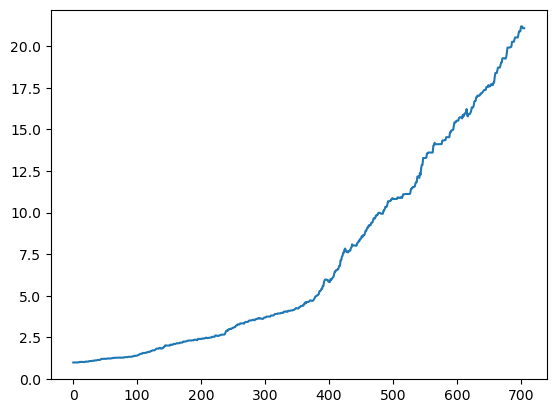

In [24]:
capital_list = [1,]
cap = 1

for row in data_to_backtest.iterrows():
    if row[1]['predict'] > 0.2:
        print(f'在{row[1]["day"]}进行做多，收益为{row[1]["index_return"]}')
        cap += cap * row[1]['index_return'] / 100
        capital_list.append(cap)
    elif row[1]['predict'] < -0.2:
        print(f"在{row[1]['day']}进行做空，收益为{-row[1]['index_return']}")
        cap -= cap * row[1]["index_return"] / 100
        capital_list.append(cap)
    else:
        capital_list.append(cap)

plt.plot(capital_list)
plt.show()

In [25]:
data_to_backtest['cap'] = pd.Series(capital_list)
data_to_backtest

,day,index_return,predict,cap
0,1,0.10,-0.159120,1.000000
1,2,0.02,-0.062834,1.000000
2,3,-0.29,-0.025465,1.000000
3,4,-1.15,-0.148071,1.000000
4,5,0.36,0.099315,1.000000
...,...,...,...,...
700,701,0.92,-0.082124,21.176880
701,702,-0.10,-0.193279,21.176880
702,703,-0.49,0.234850,21.176880
703,704,0.52,0.106943,21.073113
